In [1]:
import os
import gc
import string
import math
import numpy as np

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import albumentations as A
from albumentations import Compose
from PIL import Image
from skimage import io, transform

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import string
from nltk.corpus import wordnet
from typing import List, Optional, Union, Dict, Tuple

import warnings
warnings.filterwarnings('ignore')

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Số GPU khả dụng:", torch.cuda.device_count())
    print("Tên GPU đang dùng:", torch.cuda.get_device_name(0))
    print("Device mặc định:", torch.cuda.current_device())
else:
    print("Đang chạy trên CPU")


PyTorch version: 2.8.0+cu128
CUDA available: True
Số GPU khả dụng: 1
Tên GPU đang dùng: NVIDIA A40
Device mặc định: 0


# Config

In [3]:
BASE_DIR = ''

# DATASET_DIR = 'vivqa-dataset'
# IMAGES_DIR = os.path.join(DATASET_DIR, 'images')
IMAGES_DIR = "/root/VIT5_VIT_Finetune/data/preprocessed_images"

# TRAIN_PATH = os.path.join(DATASET_DIR, 'train.csv')
TRAIN_PATH = "/root/VIT5_VIT_Finetune/data/text/evaluate_60k_data_balanced.csv"

# TEST_PATH = os.path.join(DATASET_DIR, 'test.csv')

In [4]:
from yacs.config import CfgNode
import yaml

config_file = "/root/VIT5_VIT_Finetune/vit5_vit_generate.yaml"

with open(config_file, "r") as stream:
    try:
        CONFIG =  CfgNode(init_dict=yaml.safe_load(stream))
    except yaml.YAMLError as exc:
        print(exc)

print(CONFIG.dump())

MODEL:
  DEVICE: cuda
  GENERATOR:
    EARLY_STOPPING: true
    LENGTH_PENALTY: 1.5
    MAX_LENGTH: 12
    MIN_LENGTH: 1
    NO_REPEAT_NGRAM_SIZE: 3
    NUM_BEAMS: 4
  NAME: vit5_vit_generate
  TEXT_EMBEDDING:
    PRETRAINED_NAME: VietAI/vit5-base
  TOKENIZER:
    MAX_INPUT_LENGTH: 40
    MAX_TARGET_LENGTH: 10
    PADDING: max_length
    RETURN_ATTENTION_MASK: true
    TRUNCATION: true
  VISION_EMBEDDING:
    D_PRETRAINED_FEATURE: 768
    PRETRAINED_NAME: google/vit-base-patch16-224-in21k
TRAINING:
  BATCH_SIZE: 8
  CHECKPOINT_PATH: ViVQA-Models
  EPOCHS: 100
  LEARNING_RATE: 1.0e-06
  METRIC_BEST: em
  PATIENCE: 5
  WEIGHT_DECAY: 0.001
  WORKERS: 0



In [5]:
# set n epochs
CONFIG.TRAINING.EPOCHS = 3
CONFIG.TRAINING.METRIC_BEST = 'wups'
CONFIG.TRAINING.BATCH_SIZE = 64
CONFIG.TRAINING.WORKERS = 12
CONFIG.MODEL.GENERATOR.MAX_LENGTH = 20

In [6]:
print(CONFIG.dump())

MODEL:
  DEVICE: cuda
  GENERATOR:
    EARLY_STOPPING: true
    LENGTH_PENALTY: 1.5
    MAX_LENGTH: 20
    MIN_LENGTH: 1
    NO_REPEAT_NGRAM_SIZE: 3
    NUM_BEAMS: 4
  NAME: vit5_vit_generate
  TEXT_EMBEDDING:
    PRETRAINED_NAME: VietAI/vit5-base
  TOKENIZER:
    MAX_INPUT_LENGTH: 40
    MAX_TARGET_LENGTH: 10
    PADDING: max_length
    RETURN_ATTENTION_MASK: true
    TRUNCATION: true
  VISION_EMBEDDING:
    D_PRETRAINED_FEATURE: 768
    PRETRAINED_NAME: google/vit-base-patch16-224-in21k
TRAINING:
  BATCH_SIZE: 64
  CHECKPOINT_PATH: ViVQA-Models
  EPOCHS: 3
  LEARNING_RATE: 1.0e-06
  METRIC_BEST: wups
  PATIENCE: 5
  WEIGHT_DECAY: 0.001
  WORKERS: 12



# Prepare Dataset

In [8]:
# Load train.csv
train_df = pd.read_csv(TRAIN_PATH)

import ast
import random

# Function to safely parse answers if they are string representations of lists
def parse_answers(answers):
    if isinstance(answers, str):
        try:
            return ast.literal_eval(answers)
        except (ValueError, SyntaxError):
            raise ValueError(f"Invalid format in answers column: {answers}")
    return answers

# Apply parsing to ensure 'answers' column contains actual lists
train_df['answers'] = train_df['answers'].apply(parse_answers)

# Select a random answer for each row
train_df['answer'] = train_df['answers'].apply(lambda x: random.choice(x) if isinstance(x, list) and len(x) > 0 else x)


print(f'Train shape: {train_df.shape}')

Train shape: (37077, 77)


In [9]:
train_df[['question', 'answer', 'answers']].head()

,question,answer,answers
0,Mối quan hệ giữa người trượt ván và đám đông l...,Khán giả đang xem người trượt ván,"[Người trượt ván biểu diễn cho đám đông, Đám đ..."
1,Mối quan hệ giữa người ném bóng và người đánh ...,Sự cạnh tranh thể thao,"[Đối đầu trong trận đấu, Người ném cố gắng loạ..."
2,Người đàn ông trên thuyền đang làm gì?,Chở nhiều đồ,"[Ngồi trên thuyền, Bán đồ tiếp tế, Chở nhiều đ..."
3,Mối quan hệ giữa người đánh bóng và đám đông l...,"Một bên chơi, một bên xem.","[Người chơi trình diễn cho đám đông., Đám đông..."
4,Tại sao khán đài lại đông khán giả như vậy?,Để cổ vũ đội nhà,"[Vì trận đấu hấp dẫn, Để xem bóng chày, Để cổ ..."


In [10]:
from sklearn.model_selection import train_test_split

X = train_df[['question', 'answer', 'image_name']]

train_X, test_X = train_test_split(
    X, 
    test_size=0.2, 
    random_state=42
)
# Create dataframes for training and validation sets
train_df = pd.DataFrame({'question': train_X['question'], 'answer': train_X['answer'], 'img_name': train_X['image_name']})
test_df = pd.DataFrame({'question': test_X['question'], 'answer': test_X['answer'], 'img_name': test_X['image_name']})

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(f'Train shape: {train_df.shape}')
print(f'Test shape: {test_df.shape}')

Train shape: (29661, 3)
Test shape: (7416, 3)


## Split train & valid dataset

In [11]:
X = train_df[['question', 'answer', 'img_name']]

train_X, valid_X = train_test_split(
    X, 
    test_size=0.2, 
    random_state=42
)
# Create dataframes for training and validation sets
train_df = pd.DataFrame({'question': train_X['question'], 'answer': train_X['answer'], 'img_name': train_X['img_name']})
valid_df = pd.DataFrame({'question': valid_X['question'], 'answer': valid_X['answer'], 'img_name': valid_X['img_name']})

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

print(f'Train shape: {train_df.shape}')
print(f'Valid shape: {valid_df.shape}')

Train shape: (23728, 3)
Valid shape: (5933, 3)


In [12]:
train_df.head()

,question,answer,img_name
0,Mối quan hệ giữa đồng hồ và ngân hàng trong cá...,Đồng hồ bên ngoài ngân hàng,000000512143.jpg
1,Cầu ở đâu so với tháp đồng hồ?,Ở phía sau tháp,000000090477.jpg
2,Con mèo có vẻ đang quan tâm đến điều gì ở chiế...,Có lẽ chỉ là một chỗ để ngồi.,000000317715.jpg
3,Các băng ghế được sắp xếp như thế nào trên con...,Dọc theo con đường,000000452381.jpg
4,Con bò đang đứng ở đâu trên đường phố?,Trên đường,000000445603.jpg


## Build dataset class

In [13]:
# Build dataset class
class ViVQA_Dataset(torch.utils.data.Dataset):
  """
  Dataset class for the ViVQA dataset.
  """
  def __init__(self, df, img_dir):
    self.df = df
    self.img_dir = img_dir

  def __len__(self):
    return self.df.shape[0]

  def __getitem__(self, idx):
    question = self.df.loc[idx, 'question']
    answer = self.df.loc[idx, 'answer']
    img_name = self.df.loc[idx, 'img_name']
    # quest_type = self.df.loc[idx, 'type']

    img_file = os.path.join(self.img_dir, img_name)

    # assert os.path.exists(img_file), f"File {img_file} not found"
    # print(img_file)

    return {'image':img_file, 'question':question, 'answer':answer}

In [14]:
train_dataset = ViVQA_Dataset(train_df, IMAGES_DIR)
valid_dataset = ViVQA_Dataset(valid_df, IMAGES_DIR)

test_df.reset_index(drop=True, inplace=True)
test_dataset = ViVQA_Dataset(test_df, IMAGES_DIR)

print(f'[INFO] Train size: {len(train_dataset)}')
print(f'[INFO] Valid size: {len(valid_dataset)}')
print(f'[INFO] Test size:  {len(test_dataset)}')

[INFO] Train size: 23728
[INFO] Valid size: 5933
[INFO] Test size:  7416


In [15]:
# Visualize 'no_' images in dataset
def plot_img(dataset_show, no_):
    images, questions, answers = [],[],[]
    random_idx = np.random.choice(len(dataset_show),no_)
    for i in random_idx:
        data = dataset_show.__getitem__(i)
        image = data['image']
        question = data['question']
        answer = data['answer']
        images.append(image)
        questions.append(question)
        answers.append(answer)
    plt.figure(figsize=(12,8))
    for idx in range(0,no_):
        img_path = images[idx]
        image = Image.open(img_path).convert('RGB')
        plt.subplot(2,no_,idx+1)
        plt.title('Q: ' + questions[idx] + '\n A: '+ answers[idx])
        plt.imshow(image)
        plt.axis('off')
    plt.show()

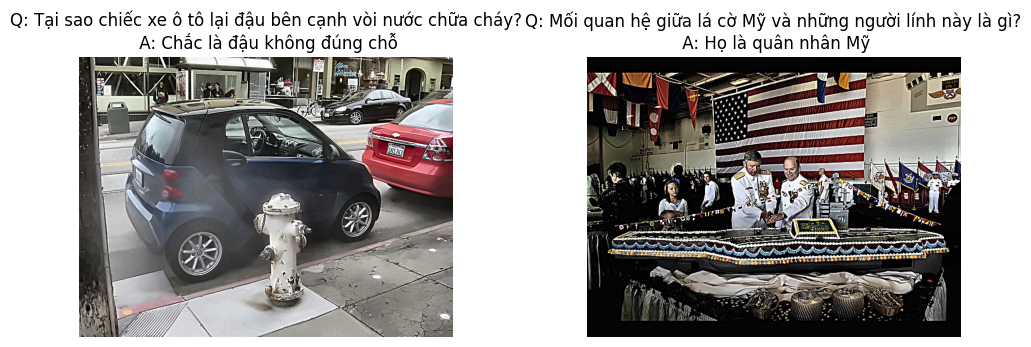

In [16]:
# Visualize 2 images in dataset
plot_img(train_dataset, 2)

# Metrics

## CIDEr

In [17]:
import copy
from collections import defaultdict
import math

def precook(s, n=4):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = str(s).split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def __init__(self, refs, test=None, n=4, sigma=6.0, doc_frequency=None, ref_len=None):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.doc_frequency = defaultdict(float)
        self.ref_len = None

        for k in range(len(refs)):
            self.crefs.append(cook_refs(refs[k]))
            if test is not None:
                self.ctest.append(cook_test(test[k][0]))  ## N.B.: -1
            else:
                self.ctest.append(None)  # lens of crefs and ctest have to match

        if doc_frequency is None and ref_len is None:
            # compute idf
            self.compute_doc_freq()
            # compute log reference length
            self.ref_len = np.log(float(len(self.crefs)))
        else:
            self.doc_frequency = doc_frequency
            self.ref_len = ref_len

    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.doc_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.doc_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    # vrama91 : added clipping
                    val[n] += min(vec_hyp[n][ngram], vec_ref[n][ngram]) * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
                # vrama91: added a length based gaussian penalty
                val[n] *= np.e**(-(delta**2)/(2*self.sigma**2))
            return val

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self):
        # compute cider score
        score = self.compute_cider()
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)

## Extract match

In [18]:
class Exact_Match:
    def compute_score(self, y_true, y_pred):
        if y_true==y_pred:
            return 1
        else:
            return 0

## F1 Score

In [19]:
class F1:
  def Precision(self,y_true,y_pred):
    if y_pred is None:
       return 0
    common = set(y_true) & set(y_pred)
    return len(common) / len(set(y_pred))

  def Recall(self,y_true,y_pred):
    common = set(y_true) & set(y_pred)
    return len(common) / len(set(y_true))

  def compute_score(self,y_true,y_pred):
    if len(y_pred) == 0 or len(y_true) == 0:
        return int(y_pred == y_true)

    precision = self.Precision(y_true, y_pred)
    recall = self.Recall(y_true, y_pred)

    if precision == 0 or recall == 0:
        return 0
    f1 = 2*precision*recall / (precision+recall)
    return f1

## Wup

In [20]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

class Wup:
    def get_semantic_field(self,a):
        weight = 1.0
        semantic_field = wordnet.synsets(str(a), pos=wordnet.NOUN)
        return (semantic_field,weight)

    def get_stem_word(self,a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)
    def compute_score(self, a: str, b: str, similarity_threshold: float = 0.9):
        """
        Returns Wu-Palmer similarity score.
        More specifically, it computes:
            max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
            where interp is a 'interpretation field'
        """
        global_weight=1.0

        (a,global_weight_a)=self.get_stem_word(a)
        (b,global_weight_b)=self.get_stem_word(b)
        global_weight = min(global_weight_a,global_weight_b)

        if a==b:
            # they are the same
            return 1.0*global_weight

        if a==[] or b==[]:
            return 0

        interp_a,weight_a = self.get_semantic_field(a)
        interp_b,weight_b = self.get_semantic_field(b)

        if interp_a == [] or interp_b == []:
            return 0

        # we take the most optimistic interpretation
        global_max=0.0
        for x in interp_a:
            for y in interp_b:
                local_score=x.wup_similarity(y)
                if local_score > global_max:
                    global_max=local_score

        # we need to use the semantic fields and therefore we downweight
        # unless the score is high which indicates both are synonyms
        if global_max < similarity_threshold:
            interp_weight = 0.1
        else:
            interp_weight = 1.0

        final_score=global_max*weight_a*weight_b*interp_weight*global_weight
        return final_score

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Score Calculator

In [21]:
import re
import unicodedata

def normalize_text(text):
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = text.lower().strip()
    return text

def preprocess_sentence(sentence: str, tokenizer=None):
    sentence = sentence.lower()
    sentence = unicodedata.normalize('NFC', sentence)
    sentence = re.sub(r"[“”]", "\"", sentence)
    sentence = re.sub(r"!", " ! ", sentence)
    sentence = re.sub(r"\?", " ? ", sentence)
    sentence = re.sub(r":", " : ", sentence)
    sentence = re.sub(r";", " ; ", sentence)
    sentence = re.sub(r",", " , ", sentence)
    sentence = re.sub(r"\"", " \" ", sentence)
    sentence = re.sub(r"'", " ' ", sentence)
    sentence = re.sub(r"\(", " ( ", sentence)
    sentence = re.sub(r"\[", " [ ", sentence)
    sentence = re.sub(r"\)", " ) ", sentence)
    sentence = re.sub(r"\]", " ] ", sentence)
    sentence = re.sub(r"/", " / ", sentence)
    sentence = re.sub(r"\.", " . ", sentence)
    sentence = re.sub(r"-", " - ", sentence)
    sentence = re.sub(r"\$", " $ ", sentence)
    sentence = re.sub(r"\&", " & ", sentence)
    sentence = re.sub(r"\*", " * ", sentence)
    # tokenize the sentence
    if tokenizer is None:
        tokenizer = lambda s: s
    sentence = tokenizer(sentence)
    sentence = " ".join(sentence.strip().split()) # remove duplicated spaces
    tokens = sentence.strip().split()

    return tokens

class ScoreCalculator:
    def __init__(self):
        self.f1_caculate=F1()
        self.em_caculate=Exact_Match()
        self.Wup_caculate=Wup()
    #F1 score character level
    def f1_char(self,labels: List[str], preds: List[str]) -> float:
        scores=[]
        for i in range(len(labels)):
            scores.append(self.f1_caculate.compute_score(str(preprocess_sentence(normalize_text(labels[i]))).split(),str(preprocess_sentence(normalize_text(preds[i]))).split()))
        return np.mean(scores)

    #F1 score token level
    def f1_token(self,labels: List[str], preds: List[str]) -> float:
        scores=[]
        for i in range(len(labels)):
            scores.append(self.f1_caculate.compute_score(str(preprocess_sentence(normalize_text(labels[i]))).split(),str(preprocess_sentence(normalize_text(preds[i]))).split()))
        return np.mean(scores)
    #Excat match score
    def em(self,labels: List[str], preds: List[str]) -> float:
        scores=[]
        for i in range(len(labels)):
            scores.append(self.em_caculate.compute_score(str(preprocess_sentence(normalize_text(labels[i]))).split(),str(preprocess_sentence(normalize_text(preds[i]))).split()))
        return np.mean(scores)
    #Wup score
    def wup(self,labels: List[str], preds: List[str]) -> float:
        scores=[]
        for i in range(len(labels)):
            scores.append(self.Wup_caculate.compute_score(str(preprocess_sentence(normalize_text(labels[i]))).split(),str(preprocess_sentence(normalize_text(preds[i]))).split()))
        return np.mean(scores)
    #Cider score
    def cider_score(self,labels: List[str], preds: List[str]) -> float:
        labels=[[preprocess_sentence(normalize_text(label))] for label in labels]
        preds=[[preprocess_sentence(normalize_text(pred))] for pred in preds ]
        cider_caculate= CiderScorer(labels, test=preds, n=4, sigma=6.)
        scores,_=cider_caculate.compute_score()
        return scores

# Model

In [22]:
from typing import Optional, Tuple, Union
import copy
from transformers import T5PreTrainedModel,T5Config, AutoModel, AutoConfig, AutoTokenizer, ViTImageProcessor
from transformers.models.t5.modeling_t5 import *
from transformers.modeling_outputs  import (
    BaseModelOutput,
    BaseModelOutputWithPastAndCrossAttentions,
    Seq2SeqLMOutput,
    Seq2SeqModelOutput,
)
from torch.nn import CrossEntropyLoss
from torch import optim
from transformers import AutoModel
from torch.utils.checkpoint import checkpoint
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map

In [23]:
__HEAD_MASK_WARNING_MSG = ""

class JoinT5Encoder(T5Stack):
    def __init__(self, config, embed_tokens=None):
        super(T5Stack, self).__init__(config)
        self.embed_tokens = embed_tokens
        self.is_decoder = config.is_decoder

        self.block = nn.ModuleList(
            [T5Block(config, has_relative_attention_bias=bool(i == 0)) for i in range(config.num_layers)]
        )
        self.final_layer_norm = T5LayerNorm(config.d_model, eps=config.layer_norm_epsilon)
        self.dropout = nn.Dropout(config.dropout_rate)

        self.visual_embedding = AutoModel.from_pretrained(config.vision_model)
        for param in self.visual_embedding.parameters():
            param.requires_grad = False
        self.project_vision=nn.Linear(config.d_vision,config.d_model)

        # Initialize weights and apply final processing
        self.post_init()
        # Model parallel
        self.model_parallel = False
        self.device_map = None
        self.gradient_checkpointing = True
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        pixel_values=None,
        ocr_info=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        inputs_embeds=None,
        head_mask=None,
        cross_attn_head_mask=None,
        past_key_values=None,
        use_cache=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        # Model parallel
        if self.model_parallel:
            torch.cuda.set_device(self.first_device)
            self.embed_tokens = self.embed_tokens.to(self.first_device)
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        if input_ids is not None and inputs_embeds is not None:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(
                f"You cannot specify both {err_msg_prefix}input_ids and {err_msg_prefix}inputs_embeds at the same time"
            )
        elif input_ids is not None:
            input_shape = input_ids.size()
            input_ids = input_ids.view(-1, input_shape[-1])
        elif inputs_embeds is not None:
            input_shape = inputs_embeds.size()[:-1]
        else:
            err_msg_prefix = "decoder_" if self.is_decoder else ""
            raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")

        if inputs_embeds is None:
            assert self.embed_tokens is not None, "You have to initialize the model with valid token embeddings"
            inputs_embeds = self.embed_tokens(input_ids)
        B, L = inputs_embeds.size()[:-1]
        img_feat = self.visual_embedding(pixel_values).last_hidden_state
        img_feat = self.project_vision(img_feat)
        V_L = img_feat.size(1)
        inputs_embeds = torch.cat([inputs_embeds, img_feat], dim=1)
        batch_size = B

        if use_cache is True:
            assert self.is_decoder, f"`use_cache` can only be set to `True` if {self} is used as a decoder"

        if attention_mask is None:
            attention_mask = input_ids.ne(self.config.pad_token_id).to(dtype=inputs_embeds.dtype, device=inputs_embeds.device)

        vis_attention_mask = attention_mask.new_ones(B, V_L)
        attention_mask = torch.cat([vis_attention_mask, attention_mask], dim=1)

        if self.is_decoder and encoder_attention_mask is None and encoder_hidden_states is not None:
            encoder_seq_length = encoder_hidden_states.shape[1]
            encoder_attention_mask = torch.ones(
                batch_size, encoder_seq_length, device=inputs_embeds.device, dtype=torch.long
            )

        # initialize past_key_values with `None` if past does not exist
        if past_key_values is None:
            past_key_values = [None] * len(self.block)

        # We can provide a self-attention mask of dimensions [batch_size, from_seq_length, to_seq_length]
        # ourselves in which case we just need to make it broadcastable to all heads.
        extended_attention_mask = self.get_extended_attention_mask(attention_mask, (B, L+V_L))

        # If a 2D or 3D attention mask is provided for the cross-attention
        # we need to make broadcastable to [batch_size, num_heads, seq_length, seq_length]
        if self.is_decoder and encoder_hidden_states is not None:
            encoder_batch_size, encoder_sequence_length, _ = encoder_hidden_states.size()
            encoder_hidden_shape = (encoder_batch_size, encoder_sequence_length)
            if encoder_attention_mask is None:
                encoder_attention_mask = torch.ones(encoder_hidden_shape, device=inputs_embeds.device)
            encoder_extended_attention_mask = self.invert_attention_mask(encoder_attention_mask)
        else:
            encoder_extended_attention_mask = None

        # Prepare head mask if needed
        head_mask = self.get_head_mask(head_mask, self.config.num_layers)
        cross_attn_head_mask = self.get_head_mask(cross_attn_head_mask, self.config.num_layers)
        present_key_value_states = () if use_cache else None
        all_hidden_states = () if output_hidden_states else None
        all_attentions = () if output_attentions else None
        all_cross_attentions = () if (output_attentions and self.is_decoder) else None
        position_bias = None
        encoder_decoder_position_bias = None

        hidden_states = self.dropout(inputs_embeds)

        for i, (layer_module, past_key_value) in enumerate(zip(self.block, past_key_values)):
            layer_head_mask = head_mask[i]
            cross_attn_layer_head_mask = cross_attn_head_mask[i]
            # Model parallel
            if self.model_parallel:
                torch.cuda.set_device(hidden_states.device)
                # Ensure that attention_mask is always on the same device as hidden_states
                if attention_mask is not None:
                    attention_mask = attention_mask.to(hidden_states.device)
                if position_bias is not None:
                    position_bias = position_bias.to(hidden_states.device)
                if encoder_hidden_states is not None:
                    encoder_hidden_states = encoder_hidden_states.to(hidden_states.device)
                if encoder_extended_attention_mask is not None:
                    encoder_extended_attention_mask = encoder_extended_attention_mask.to(hidden_states.device)
                if encoder_decoder_position_bias is not None:
                    encoder_decoder_position_bias = encoder_decoder_position_bias.to(hidden_states.device)
                if layer_head_mask is not None:
                    layer_head_mask = layer_head_mask.to(hidden_states.device)
                if cross_attn_layer_head_mask is not None:
                    cross_attn_layer_head_mask = cross_attn_layer_head_mask.to(hidden_states.device)
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            if self.gradient_checkpointing and self.training:
                if use_cache:
                    logger.warning(
                        "`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`..."
                    )
                    use_cache = False

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return tuple(module(*inputs, use_cache, output_attentions))

                    return custom_forward

                layer_outputs = checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    extended_attention_mask,
                    position_bias,
                    encoder_hidden_states,
                    encoder_extended_attention_mask,
                    encoder_decoder_position_bias,
                    layer_head_mask,
                    cross_attn_layer_head_mask,
                    None,  # past_key_value is always None with gradient checkpointing
                )
            else:
                layer_outputs = layer_module(
                    hidden_states,
                    attention_mask=extended_attention_mask,
                    position_bias=position_bias,
                    encoder_hidden_states=encoder_hidden_states,
                    encoder_attention_mask=encoder_extended_attention_mask,
                    encoder_decoder_position_bias=encoder_decoder_position_bias,
                    layer_head_mask=layer_head_mask,
                    cross_attn_layer_head_mask=cross_attn_layer_head_mask,
                    past_key_value=past_key_value,
                    use_cache=use_cache,
                    output_attentions=output_attentions,
                )

            # layer_outputs is a tuple with:
            # hidden-states, key-value-states, (self-attention position bias), (self-attention weights), (cross-attention position bias), (cross-attention weights)
            if use_cache is False:
                layer_outputs = layer_outputs[:1] + (None,) + layer_outputs[1:]

            hidden_states, present_key_value_state = layer_outputs[:2]

            # We share the position biases between the layers - the first layer store them
            # layer_outputs = hidden-states, key-value-states (self-attention position bias), (self-attention weights),
            # (cross-attention position bias), (cross-attention weights)
            position_bias = layer_outputs[2]
            if self.is_decoder and encoder_hidden_states is not None:
                encoder_decoder_position_bias = layer_outputs[4 if output_attentions else 3]
            # append next layer key value states
            if use_cache:
                present_key_value_states = present_key_value_states + (present_key_value_state,)

            if output_attentions:
                all_attentions = all_attentions + (layer_outputs[3],)
                if self.is_decoder:
                    all_cross_attentions = all_cross_attentions + (layer_outputs[5],)

            # Model Parallel: If it's the last layer for that device, put things on the next device
            if self.model_parallel:
                for k, v in self.device_map.items():
                    if i == v[-1] and "cuda:" + str(k) != self.last_device:
                        hidden_states = hidden_states.to("cuda:" + str(k + 1))

        hidden_states = self.final_layer_norm(hidden_states)
        hidden_states = self.dropout(hidden_states)

        # Add last layer
        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(
                v
                for v in [
                    hidden_states,
                    present_key_value_states,
                    all_hidden_states,
                    all_attentions,
                    all_cross_attentions,
                ]
                if v is not None
            )
        return BaseModelOutputWithPastAndCrossAttentions(
            last_hidden_state=hidden_states,
            past_key_values=present_key_value_states,
            hidden_states=all_hidden_states,
            attentions=all_attentions,
            cross_attentions=all_cross_attentions,
        )

In [24]:
class ViT5ForConditionalGeneration(T5ForConditionalGeneration):
    _keys_to_ignore_on_load_missing = [
        r"encoder.embed_tokens.weight",
        r"decoder.embed_tokens.weight",
        r"lm_head.weight",
    ]
    _keys_to_ignore_on_load_unexpected = [
        r"decoder.block.0.layer.1.EncDecAttention.relative_attention_bias.weight",
    ]

    def __init__(self, config: T5Config):
        super().__init__(config)
        self.model_dim = config.d_model

        self.shared = nn.Embedding(config.vocab_size, config.d_model)

        encoder_config = copy.deepcopy(config)
        encoder_config.is_decoder = False
        encoder_config.use_cache = False
        encoder_config.is_encoder_decoder = False
        self.encoder = JoinT5Encoder(encoder_config, self.shared)

        decoder_config = copy.deepcopy(config)
        decoder_config.is_decoder = True
        decoder_config.is_encoder_decoder = False
        decoder_config.num_layers = config.num_decoder_layers
        self.decoder = T5Stack(decoder_config, self.shared)

        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Initialize weights and apply final processing
        self.post_init()

        # Model parallel
        self.model_parallel = False
        self.device_map = None

    def parallelize(self, device_map=None):
        self.device_map = (
            get_device_map(len(self.encoder.block), range(torch.cuda.device_count()))
            if device_map is None
            else device_map
        )
        assert_device_map(self.device_map, len(self.encoder.block))
        self.encoder.parallelize(self.device_map)
        self.decoder.parallelize(self.device_map)
        self.lm_head = self.lm_head.to(self.decoder.first_device)
        self.model_parallel = True

    def deparallelize(self):
        self.encoder.deparallelize()
        self.decoder.deparallelize()
        self.encoder = self.encoder.to("cpu")
        self.decoder = self.decoder.to("cpu")
        self.lm_head = self.lm_head.to("cpu")
        self.model_parallel = False
        self.device_map = None
        torch.cuda.empty_cache()

    def get_input_embeddings(self):
        return self.shared

    def set_input_embeddings(self, new_embeddings):
        self.shared = new_embeddings
        self.encoder.set_input_embeddings(new_embeddings)
        self.decoder.set_input_embeddings(new_embeddings)

    def set_output_embeddings(self, new_embeddings):
        self.lm_head = new_embeddings

    def get_output_embeddings(self):
        return self.lm_head

    def get_encoder(self):
        return self.encoder

    def get_decoder(self):
        return self.decoder

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        ocr_info=None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        decoder_head_mask: Optional[torch.FloatTensor] = None,
        cross_attn_head_mask: Optional[torch.Tensor] = None,
        encoder_outputs: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        past_key_values: Optional[Tuple[Tuple[torch.Tensor]]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple[torch.FloatTensor], Seq2SeqLMOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[-100, 0, ...,
            config.vocab_size - 1]`. All labels set to `-100` are ignored (masked), the loss is only computed for
            labels in `[0, ..., config.vocab_size]`
        Returns:
        Examples:
        ```python
        >>> from transformers import T5Tokenizer, T5ForConditionalGeneration
        >>> tokenizer = T5Tokenizer.from_pretrained("t5-small")
        >>> model = T5ForConditionalGeneration.from_pretrained("t5-small")
        >>> # training
        >>> input_ids = tokenizer("The <extra_id_0> walks in <extra_id_1> park", return_tensors="pt").input_ids
        >>> labels = tokenizer("<extra_id_0> cute dog <extra_id_1> the <extra_id_2>", return_tensors="pt").input_ids
        >>> outputs = model(input_ids=input_ids, labels=labels)
        >>> loss = outputs.loss
        >>> logits = outputs.logits
        >>> # inference
        >>> input_ids = tokenizer(
        ...     "summarize: studies have shown that owning a dog is good for you", return_tensors="pt"
        ... ).input_ids  # Batch size 1
        >>> outputs = model.generate(input_ids)
        >>> print(tokenizer.decode(outputs[0], skip_special_tokens=True))
        >>> # studies have shown that owning a dog is good for you.
        ```"""
        use_cache = use_cache if use_cache is not None else self.config.use_cache
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # FutureWarning: head_mask was separated into two input args - head_mask, decoder_head_mask
        if head_mask is not None and decoder_head_mask is None:
            if self.config.num_layers == self.config.num_decoder_layers:
                warnings.warn(__HEAD_MASK_WARNING_MSG, FutureWarning)
                decoder_head_mask = head_mask

        # Encode if needed (training, first prediction pass)
        if encoder_outputs is None:
            # Convert encoder inputs in embeddings if needed
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                pixel_values=pixel_values,
                ocr_info=ocr_info,
                attention_mask=attention_mask,
                inputs_embeds=inputs_embeds,
                head_mask=head_mask,
                output_attentions=output_attentions,
                output_hidden_states=output_hidden_states,
                return_dict=return_dict,
            )
        elif return_dict and not isinstance(encoder_outputs, BaseModelOutput):
            encoder_outputs = BaseModelOutput(
                last_hidden_state=encoder_outputs[0],
                hidden_states=encoder_outputs[1] if len(encoder_outputs) > 1 else None,
                attentions=encoder_outputs[2] if len(encoder_outputs) > 2 else None,
            )

        hidden_states = encoder_outputs[0]

        if self.model_parallel:
            torch.cuda.set_device(self.decoder.first_device)

        if labels is not None and decoder_input_ids is None and decoder_inputs_embeds is None:
            # get decoder inputs from shifting lm labels to the right
            decoder_input_ids = self._shift_right(labels)

        # Set device for model parallelism
        if self.model_parallel:
            torch.cuda.set_device(self.decoder.first_device)
            hidden_states = hidden_states.to(self.decoder.first_device)
            if decoder_input_ids is not None:
                decoder_input_ids = decoder_input_ids.to(self.decoder.first_device)
            if attention_mask is not None:
                attention_mask = attention_mask.to(self.decoder.first_device)
            if decoder_attention_mask is not None:
                decoder_attention_mask = decoder_attention_mask.to(self.decoder.first_device)

        if attention_mask is None:
            attention_mask = input_ids.ne(self.config.pad_token_id).to(dtype=hidden_states.dtype, device=hidden_states.device)
        B, L = attention_mask.size()
        V_L = encoder_outputs[0].size(1) - L
        vis_attention_mask = attention_mask.new_ones(B, V_L)
        encoder_attention_mask = torch.cat([vis_attention_mask, attention_mask], dim=1)
        # Decode
        decoder_outputs = self.decoder(
            input_ids=decoder_input_ids,
            attention_mask=decoder_attention_mask,
            inputs_embeds=decoder_inputs_embeds,
            past_key_values=past_key_values,
            encoder_hidden_states=hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            head_mask=decoder_head_mask,
            cross_attn_head_mask=cross_attn_head_mask,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = decoder_outputs[0]

        # Set device for model parallelism
        if self.model_parallel:
            torch.cuda.set_device(self.encoder.first_device)
            self.lm_head = self.lm_head.to(self.encoder.first_device)
            sequence_output = sequence_output.to(self.lm_head.weight.device)

        if self.config.tie_word_embeddings:
            # Rescale output before projecting on vocab
            # See https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/transformer/transformer.py#L586
            sequence_output = sequence_output * (self.model_dim**-0.5)

        lm_logits = self.lm_head(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(lm_logits.view(-1, lm_logits.size(-1)), labels.view(-1))
            # TODO(thom): Add z_loss https://github.com/tensorflow/mesh/blob/fa19d69eafc9a482aff0b59ddd96b025c0cb207d/mesh_tensorflow/layers.py#L666

        if not return_dict:
            output = (lm_logits,) + decoder_outputs[1:] + encoder_outputs
            return ((loss,) + output) if loss is not None else output

        return Seq2SeqLMOutput(
            loss=loss,
            logits=lm_logits,
            past_key_values=decoder_outputs.past_key_values,
            decoder_hidden_states=decoder_outputs.hidden_states,
            decoder_attentions=decoder_outputs.attentions,
            cross_attentions=decoder_outputs.cross_attentions,
            encoder_last_hidden_state=encoder_outputs.last_hidden_state,
            encoder_hidden_states=encoder_outputs.hidden_states,
            encoder_attentions=encoder_outputs.attentions,
        )

    def prepare_inputs_for_generation(
        self,
        input_ids,
        past=None,
        attention_mask=None,
        head_mask=None,
        decoder_head_mask=None,
        cross_attn_head_mask=None,
        use_cache=None,
        encoder_outputs=None,
        **kwargs
    ):

        # cut decoder_input_ids if past is used
        if past is not None:
            input_ids = input_ids[:, -1:]

        return {
            "decoder_input_ids": input_ids,
            "past_key_values": past,
            "encoder_outputs": encoder_outputs,
            "attention_mask": attention_mask,
            "head_mask": head_mask,
            "decoder_head_mask": decoder_head_mask,
            "cross_attn_head_mask": cross_attn_head_mask,
            "use_cache": use_cache,
            "pixel_values": kwargs.get("pixel_values", None),
            "ocr_info": kwargs.get("ocr_info", None),
        }

    def prepare_decoder_input_ids_from_labels(self, labels: torch.Tensor):
        return self._shift_right(labels)

    def _reorder_cache(self, past, beam_idx):
        # if decoder past is not included in output
        # speedy decoding is disabled and no need to reorder
        if past is None:
            logger.warning("You might want to consider setting `use_cache=True` to speed up decoding")
            return past

        reordered_decoder_past = ()
        for layer_past_states in past:
            # get the correct batch idx from layer past batch dim
            # batch dim of `past` is at 2nd position
            reordered_layer_past_states = ()
            for layer_past_state in layer_past_states:
                # need to set correct `past` for each of the four key / value states
                reordered_layer_past_states = reordered_layer_past_states + (
                    layer_past_state.index_select(0, beam_idx.to(layer_past_state.device)),
                )

            assert reordered_layer_past_states[0].shape == layer_past_states[0].shape
            assert len(reordered_layer_past_states) == len(layer_past_states)

            reordered_decoder_past = reordered_decoder_past + (reordered_layer_past_states,)
        return reordered_decoder_past

In [25]:
def T5_Embedding(config):
    model_config = AutoConfig.from_pretrained(config.TEXT_EMBEDDING.PRETRAINED_NAME)
    model_config.update({
        'vision_model' : config.VISION_EMBEDDING.PRETRAINED_NAME,
        'd_vision': config.VISION_EMBEDDING.D_PRETRAINED_FEATURE
        })
    embedding = ViT5ForConditionalGeneration.from_pretrained(config.TEXT_EMBEDDING.PRETRAINED_NAME, config=model_config)
    return embedding

In [26]:
class ViT5_VQA_Model(nn.Module):
    def __init__(self, config):
        super(ViT5_VQA_Model, self).__init__()
        self.config = config
        self.vision_encoder = ViTImageProcessor.from_pretrained(config.VISION_EMBEDDING.PRETRAINED_NAME)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = AutoTokenizer.from_pretrained(config.TEXT_EMBEDDING.PRETRAINED_NAME)
        self.embedding = T5_Embedding(config)

        self.generator_args ={
            'max_length': config.GENERATOR.MAX_LENGTH,
            'min_length': config.GENERATOR.MIN_LENGTH,
            'num_beams': config.GENERATOR.NUM_BEAMS,
            'length_penalty': config.GENERATOR.LENGTH_PENALTY,
            'no_repeat_ngram_size': config.GENERATOR.NO_REPEAT_NGRAM_SIZE,
            'early_stopping': config.GENERATOR.EARLY_STOPPING,
        }

    def forward(self, questions: List[str], images: List[str], labels: List[str] = None):
        encoding_pixel = self.vision_encoder(
                images=[
                    (Image.open(image_path)).convert('RGB').resize((224,224)) for image_path in images
                ],
                return_tensors="pt",
            ).pixel_values.to(self.device)
        encoded_inputs = self.tokenizer(questions,
                                max_length=self.config.TOKENIZER.MAX_INPUT_LENGTH,
                                padding=self.config.TOKENIZER.PADDING,
                                truncation=self.config.TOKENIZER.TRUNCATION,
                                return_tensors='pt',
                                return_attention_mask=self.config.TOKENIZER.RETURN_ATTENTION_MASK,
                            ).to(self.device)
        if labels is not None:
            encoded_targets = self.tokenizer(labels,
                                            max_length=self.config.TOKENIZER.MAX_TARGET_LENGTH,
                                            padding=self.config.TOKENIZER.PADDING,
                                            truncation=self.config.TOKENIZER.TRUNCATION,
                                            return_tensors='pt',
                                            return_attention_mask=self.config.TOKENIZER.RETURN_ATTENTION_MASK,
                                        ).to(self.device)
            encoded_targets[encoded_targets == self.tokenizer.pad_token_id] = -100
            inputs = {
                'input_ids': encoded_inputs.input_ids,
                'attention_mask': encoded_inputs.attention_mask,
                'labels': encoded_targets.input_ids,
                'decoder_attention_mask': encoded_targets.attention_mask,
            }
        else:
            inputs = {
                'input_ids': encoded_inputs.input_ids,
                'attention_mask': encoded_inputs.attention_mask
            }

        inputs.update({'pixel_values':encoding_pixel})

        if labels is not None:
            outputs = self.embedding(**inputs)
            return outputs.logits, outputs.loss
        else:
            pred_ids=self.embedding.generate(**inputs,**self.generator_args)
            pred_tokens=self.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
            return pred_tokens

In [27]:
class ViT5_VQA_Task:
    def __init__(self, config):
        self.save_path = os.path.join(BASE_DIR, config.TRAINING.CHECKPOINT_PATH, config.MODEL.NAME)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.num_epochs = config.TRAINING.EPOCHS
        self.patience = config.TRAINING.PATIENCE
        self.best_metric= config.TRAINING.METRIC_BEST
        self.learning_rate = config.TRAINING.LEARNING_RATE
        self.weight_decay = config.TRAINING.WEIGHT_DECAY
        self.batch_size = config.TRAINING.BATCH_SIZE
        self.num_workers = config.TRAINING.WORKERS
        self.tokenizer=AutoTokenizer.from_pretrained(config.MODEL.TEXT_EMBEDDING.PRETRAINED_NAME)
        self.base_model=ViT5_VQA_Model(config.MODEL).to(self.device)
        self.optimizer = optim.Adam(self.base_model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scaler = torch.cuda.amp.GradScaler()
        lambda1 = lambda epoch: 0.9 ** epoch
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda=lambda1)
        self.compute_score = ScoreCalculator()

    def training(self):
        if not os.path.exists(self.save_path):
          os.makedirs(self.save_path)

        train = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        valid = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

        if os.path.exists(os.path.join(self.save_path, 'last_model.pth')):
            checkpoint = torch.load(os.path.join(self.save_path, 'last_model.pth'), map_location=self.device, weights_only=False)
            self.base_model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print('Loaded the last saved model!!!')
            initial_epoch = checkpoint['epoch'] + 1
            print(f"Continue training from epoch {initial_epoch}")
        else:
            initial_epoch = 0
            print("First time training!!!")

        if os.path.exists(os.path.join(self.save_path, 'best_model.pth')):
            checkpoint = torch.load(os.path.join(self.save_path, 'best_model.pth'), map_location=self.device, weights_only=False)
            best_score = checkpoint['score']
        else:
            best_score = 0.

        threshold = 0
        self.base_model.train()
        for epoch in range(initial_epoch, self.num_epochs + initial_epoch):
            print(f"\nEpoch {epoch + 1}...")
            valid_em = 0.
            valid_wups=0.
            valid_f1 =0.
            valid_cider=0.
            train_loss = 0.
            valid_loss = 0.
            # Train
            with tqdm(desc=f'Epoch {epoch + 1} - Training  ', unit='it', total=len(train)) as pbar:
              for it, item in enumerate(train):
                  with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                      logits, loss = self.base_model(item['question'], item['image'], item['answer'])
                  self.scaler.scale(loss).backward()
                  self.scaler.step(self.optimizer)
                  self.scaler.update()
                  self.optimizer.zero_grad()
                  train_loss += loss
                  cur_loss = round(train_loss.detach().cpu().numpy() / (it + 1), 4)
                  pbar.set_postfix({'loss': cur_loss, 'lr':self.scheduler.get_last_lr()[0]})
                  pbar.update()
            self.scheduler.step()
            train_loss /=len(train)
            # Valid
            with torch.no_grad():
              with tqdm(desc=f'Epoch {epoch + 1} - Evaluation', unit='it', total=len(valid)) as pbar:
                for it, item in enumerate(valid):
                    with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=True):
                        pred_answers = self.base_model(item['question'],item['image'])
                        clean_answers=item['answer']
                        valid_loss += self.base_model(item['question'], item['image'], item['answer'])[1]
                        valid_wups +=self.compute_score.wup(clean_answers,pred_answers)
                        valid_em +=self.compute_score.em(clean_answers,pred_answers)
                        valid_f1 +=self.compute_score.f1_token(clean_answers,pred_answers)
                        valid_cider +=self.compute_score.cider_score(clean_answers,pred_answers)
                    pbar.update()
            valid_loss /=len(valid)
            valid_wups /= len(valid)
            valid_em /= len(valid)
            valid_f1 /= len(valid)
            valid_cider/=len(valid)
            print(f"Training loss: {train_loss:.4f} - Valid loss: {valid_loss:.4f} - Valid wups: {valid_wups:.4f} - Valid em: {valid_em:.4f} - Valid f1: {valid_f1:.4f} - Valid cider: {valid_cider:.4f}")
            with open(os.path.join(self.save_path, 'log.txt'), 'a') as file:
                file.write(f"Epoch {epoch + 1} - Training loss: {train_loss:.4f} - Valid loss: {valid_loss:.4f} - Valid wups: {valid_wups:.4f} - Valid em: {valid_em:.4f} - Valid f1: {valid_f1:.4f} - Valid cider: {valid_cider:.4f}\n")

            if self.best_metric =='em':
                score=valid_em
            if self.best_metric=='f1':
                score=valid_f1
            if self.best_metric=='wups':
                score=valid_wups
            if self.best_metric=='cider':
                score=valid_cider

            # Save the last model
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.base_model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'score': score}, os.path.join(self.save_path, 'last_model.pth'))

            # Save the best model
            if epoch > 0 and score <= best_score:
              threshold += 1
            else:
              threshold = 0

            if score > best_score:
                best_score = score
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.base_model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'score':score}, os.path.join(self.save_path, 'best_model.pth'))
                print(f"Saved the best model with {self.best_metric} of {score:.4f}")

            # early stopping
            if threshold >= self.patience:
                print(f"Early stopping after epoch {epoch + 1}")
                break

    def get_predict(self):
      # Load the model
      print("Loadding best model...")
      if os.path.exists(os.path.join(self.save_path, 'best_model.pth')):
          checkpoint = torch.load(os.path.join(self.save_path, 'best_model.pth'), map_location=self.device, weights_only=False)
          self.base_model.load_state_dict(checkpoint['model_state_dict'])
      else:
          print("Prediction require the model must be trained. There is no weights to load for model prediction!")
          raise FileNotFoundError("Make sure your checkpoint path is correct or the best_model.pth is available in your checkpoint path")
      # Create test_loader
      if test_dataset:
          print(f"[INFO] Test size: {len(test_dataset)}")
          test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
      else:
          raise Exception("Not found test dataset")

      print("Predicting...")
      img_path=[]
      quests=[]
      gts=[]
      preds=[]
      self.base_model.eval()
      with torch.no_grad():
          for it,item in enumerate(tqdm(test_loader)):
              answers = self.base_model(item['question'],item['image'])
              preds.extend(answers)
              img_path.extend(item['image'])
              quests.extend(item['question'])
              gts.extend(item['answer'])
      test_wups = self.compute_score.wup(gts,preds)
      test_em = self.compute_score.em(gts,preds)
      test_f1 = self.compute_score.f1_token(gts,preds)
      test_cider = self.compute_score.cider_score(gts,preds)
      print(f"\nEvaluation scores on Test - wups: {test_wups:.4f} - em: {test_em:.4f} - f1: {test_f1:.4f} - cider: {test_cider:.4f}")

      data = {
          "img_path":img_path,
          "question": quests,
          "ground_truth":gts,
          "predicts": preds
      }
      df = pd.DataFrame(data)
      df.to_csv(os.path.join(self.save_path,'result.csv'), index=False)
      print(f"Save result to: {os.path.join(self.save_path,'result.csv')}")


In [28]:
task = ViT5_VQA_Task(CONFIG)

Some weights of ViT5ForConditionalGeneration were not initialized from the model checkpoint at VietAI/vit5-base and are newly initialized: ['encoder.project_vision.bias', 'encoder.project_vision.weight', 'encoder.visual_embedding.embeddings.cls_token', 'encoder.visual_embedding.embeddings.patch_embeddings.projection.bias', 'encoder.visual_embedding.embeddings.patch_embeddings.projection.weight', 'encoder.visual_embedding.embeddings.position_embeddings', 'encoder.visual_embedding.encoder.layer.0.attention.attention.key.bias', 'encoder.visual_embedding.encoder.layer.0.attention.attention.key.weight', 'encoder.visual_embedding.encoder.layer.0.attention.attention.query.bias', 'encoder.visual_embedding.encoder.layer.0.attention.attention.query.weight', 'encoder.visual_embedding.encoder.layer.0.attention.attention.value.bias', 'encoder.visual_embedding.encoder.layer.0.attention.attention.value.weight', 'encoder.visual_embedding.encoder.layer.0.attention.output.dense.bias', 'encoder.visual_em

In [102]:
# task.training()

In [ ]:
task.get_predict()

Loadding best model...


[INFO] Test size: 7416
Predicting...


 44%|████▍     | 51/116 [04:14<05:21,  4.94s/it]

In [ ]:
from torchinfo import summary
summary(task.base_model)